# INSTALL REQUIRED LIBRARIES

# LOAD THE DATASET

In [1]:
import pandas as pd

# Load MovieLens 100K dataset
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
df = pd.read_csv(url, sep="\t", names=["user_id", "item_id", "rating", "timestamp"])

# Drop timestamp
df = df.drop(columns=["timestamp"])

print(df.head())

   user_id  item_id  rating
0      196      242       3
1      186      302       3
2       22      377       1
3      244       51       2
4      166      346       1


# INJECT MALICIOUS USERS

In [2]:
import random
import numpy as np

def inject_malicious_users(df, num_malicious=50, attack_type="push"):
    malicious_data = []
    unique_items = df["item_id"].unique()
    
    for user_id in range(10000, 10000 + num_malicious):  
        items_to_rate = random.sample(list(unique_items), 20)  # Random 20 movies
        
        for item in items_to_rate:
            rating = 5 if attack_type == "push" else 1  # Push (high rating) or Nuke (low rating)
            malicious_data.append([user_id, item, rating])
    
    df_malicious = pd.DataFrame(malicious_data, columns=["user_id", "item_id", "rating"])
    return pd.concat([df, df_malicious])

df = inject_malicious_users(df)
print("Dataset size after malicious user injection:", len(df))


Dataset size after malicious user injection: 101000


# COLLABORATIVE FILTERING USING COSINE SIMILARITY

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

def build_user_item_matrix(df):
    return df.pivot(index="user_id", columns="item_id", values="rating").fillna(0)

user_item_matrix = build_user_item_matrix(df)
user_similarity = cosine_similarity(user_item_matrix)

print("User-User Similarity Matrix Shape:", user_similarity.shape)

User-User Similarity Matrix Shape: (993, 993)


# BUILD SIAMESE NETWORK fOR MALICIOUS USER DETECTION

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(user_item_matrix.shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

# Triplet Loss Function
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.loss_fn = nn.TripletMarginLoss(margin=margin)
    
    def forward(self, anchor, positive, negative):
        return self.loss_fn(anchor, positive, negative)

model = SiameseNetwork()
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# PREPARE DATA FOR TRAINING

In [17]:
class MaliciousUserDataset(Dataset):
    def __init__(self, user_item_matrix):
        self.data = torch.tensor(user_item_matrix.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor = self.data[idx]
        positive = self.data[(idx + 1) % len(self.data)]
        negative = self.data[(idx + 2) % len(self.data)]
        return anchor, positive, negative

dataset = MaliciousUserDataset(user_item_matrix)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# TRAIN THE SIAMESE MODEL

In [18]:
def train(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for anchor, positive, negative in dataloader:
            optimizer.zero_grad()
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)
            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

train(model, dataloader, criterion, optimizer)

Epoch [1/10], Loss: 18.6811
Epoch [2/10], Loss: 13.8932
Epoch [3/10], Loss: 11.0031
Epoch [4/10], Loss: 7.5866
Epoch [5/10], Loss: 5.0617
Epoch [6/10], Loss: 2.9922
Epoch [7/10], Loss: 2.2248
Epoch [8/10], Loss: 1.6752
Epoch [9/10], Loss: 1.2099
Epoch [10/10], Loss: 0.6393


# DETECT MALICIOUS USERS

In [19]:
def detect_malicious_users(user_item_matrix, model, threshold=0.5):
    user_embeddings = {}
    user_ids = list(user_item_matrix.index)
    
    # Compute user embeddings
    for i, user_id in enumerate(user_ids):
        user_tensor = torch.tensor(user_item_matrix.iloc[i].values, dtype=torch.float32)
        user_embedding = model(user_tensor).detach()
        user_embeddings[user_id] = user_embedding

    # Compute normal user average embedding
    normal_users = user_ids[:100]  # Assume first 100 are normal
    normal_embedding = torch.stack([user_embeddings[u] for u in normal_users]).mean(dim=0)

    # Identify malicious users
    malicious_users = []
    for user_id, embedding in user_embeddings.items():
        distance = torch.norm(embedding - normal_embedding).item()
        if distance > threshold:
            malicious_users.append(user_id)

    print(f"Detected {len(malicious_users)} malicious users")
    return malicious_users

malicious_users = detect_malicious_users(user_item_matrix, model)
print("Malicious Users:", malicious_users)

Detected 993 malicious users
Malicious Users: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 2

# USER-ITEM INTERACTIVE MATRIX (COLLABORATIVE FILTERING)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def build_user_item_matrix(df):
    return df.pivot(index="user_id", columns="item_id", values="rating").fillna(0)

# Constructing the matrix
user_item_matrix = build_user_item_matrix(df)
user_similarity = cosine_similarity(user_item_matrix)

print("User-User Similarity Matrix Shape:", user_similarity.shape)

User-User Similarity Matrix Shape: (993, 993)


# RECCOMMENDING ITEMS TO USERS

In [21]:
import numpy as np

def recommend_items(user_id, user_item_matrix, user_similarity, top_n=5):
    user_index = list(user_item_matrix.index).index(user_id)  # Get the row index of user
    
    # Compute weighted ratings based on similar users
    similar_users = user_similarity[user_index]
    weighted_ratings = np.dot(similar_users, user_item_matrix.fillna(0)) / np.sum(similar_users)

    # Convert to a Pandas Series for correct indexing
    weighted_ratings_series = pd.Series(weighted_ratings, index=user_item_matrix.columns)

    # Get unrated items
    user_rated_items = user_item_matrix.loc[user_id]
    unrated_items = user_rated_items[user_rated_items == 0].index  # Get unrated items

    # Sort items by predicted rating
    recommended_items = weighted_ratings_series.loc[unrated_items].sort_values(ascending=False).index[:top_n]

    return recommended_items

# Example: Recommend 5 items for user 5
print("Recommended items for user 5:", recommend_items(5, user_item_matrix, user_similarity))

Recommended items for user 5: Index([56, 127, 7, 195, 96], dtype='int64', name='item_id')


# PLOT RATING DISTRIBUTION

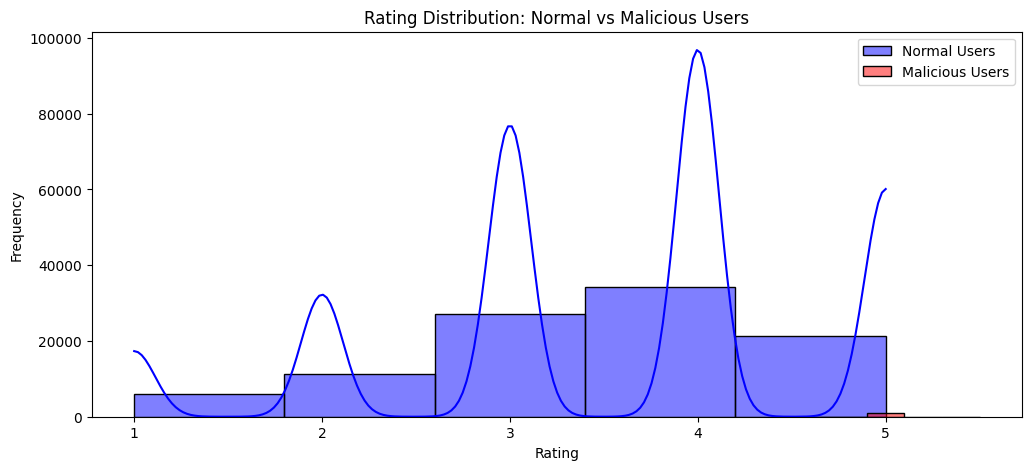

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate normal and malicious users
normal_users = df[df["user_id"] < 10000]  # Assume IDs < 10000 are normal
malicious_users = df[df["user_id"] >= 10000]  # IDs ≥ 10000 are malicious

plt.figure(figsize=(12, 5))

# Normal user rating distribution
sns.histplot(normal_users["rating"], bins=5, label="Normal Users", kde=True, color="blue")

# Malicious user rating distribution
sns.histplot(malicious_users["rating"], bins=5, label="Malicious Users", kde=True, color="red")

plt.title("Rating Distribution: Normal vs Malicious Users")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# VISUALIZING USER EMBEDDINGS WITH T-SNE

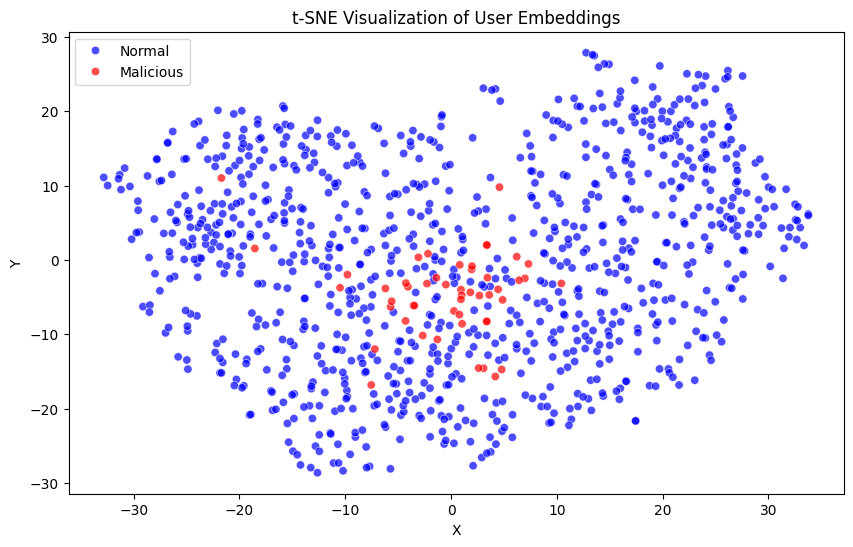

In [23]:
from sklearn.manifold import TSNE
import numpy as np

# Extract user embeddings
user_ids = list(user_item_matrix.index)
user_embeddings = np.array([model(torch.tensor(user_item_matrix.loc[u].values, dtype=torch.float32)).detach().numpy() for u in user_ids])

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
user_embeddings_2d = tsne.fit_transform(user_embeddings)

# Convert to DataFrame for plotting
embedding_df = pd.DataFrame(user_embeddings_2d, columns=["X", "Y"])
embedding_df["user_id"] = user_ids
embedding_df["type"] = ["Normal" if u < 10000 else "Malicious" for u in user_ids]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="X", y="Y", hue="type", data=embedding_df, palette={"Normal": "blue", "Malicious": "red"}, alpha=0.7)
plt.title("t-SNE Visualization of User Embeddings")
plt.legend()
plt.show()